In [350]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import PowerTransformer

In [351]:
df_imp = pd.read_excel('IMPORTACION-VOLUMEN-2023-05.xlsx', sheet_name='IMPORTACION',skiprows = 6,
                            nrows=270, header=0,usecols= 'A, G, I, K, L, U', engine='openpyxl').dropna()

df_imp.head()

,Fecha,Diesel bajo azufre,Gas licuado de petróleo,Gasolina regular,Gasolina superior,Diesel alto azufre
0,2001-01-01,0.0,194065.738095,177776.50,373963.96,566101.99
1,2001-02-01,0.0,170703.380952,123115.99,243091.07,489525.80
2,2001-03-01,0.0,161837.371429,161726.42,312084.38,575559.68
3,2001-04-01,0.0,163048.642857,127338.74,285054.89,437745.42
4,2001-05-01,0.0,171518.861905,168730.19,300913.67,552609.13


In [352]:
df_imp.tail()

,Fecha,Diesel bajo azufre,Gas licuado de petróleo,Gasolina regular,Gasolina superior,Diesel alto azufre
264,2023-01-01,1442099.08,497780.69,909391.13,578792.14,0.0
265,2023-02-01,1267967.39,652984.71,725101.20,685183.06,0.0
266,2023-03-01,1317519.91,711978.35,803262.67,633849.05,0.0
267,2023-04-01,1417182.73,647666.30,922032.39,572201.36,0.0
268,2023-05-01,1428099.62,713348.99,947633.29,668478.73,0.0


In [353]:
(df_imp.iloc[:,1] != 0).idxmax(), (df_imp.iloc[:,5] == 0).idxmax() # las volumnas se pueden sumar en una sola

(204, 204)

In [354]:
df_imp['Diesel'] = df_imp['Diesel bajo azufre'] + df_imp['Diesel alto azufre']
df_imp.drop(['Diesel bajo azufre', 'Diesel alto azufre'], axis=1, inplace=True)

In [355]:
df_imp.info(), df_imp.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Fecha                    269 non-null    datetime64[ns]
 1   Gas licuado de petróleo  269 non-null    float64       
 2   Gasolina regular         269 non-null    float64       
 3   Gasolina superior        269 non-null    float64       
 4   Diesel                   269 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 10.6 KB


(None, (269, 5))

In [356]:
df_imp.describe().applymap(lambda x: f"{int(x):,}")

,Gas licuado de petróleo,Gasolina regular,Gasolina superior,Diesel
count,269,269,269,269
mean,"399,026","381,883","478,288","863,979"
std,"190,173","219,364","153,277","276,545"
min,"100,561","81,015","170,292","229,764"
25%,"218,257","201,907","363,352","678,749"
50%,"396,363","305,285","456,588","824,047"
75%,"540,671","528,347","582,374","1,050,560"
max,"960,840","987,872","1,227,173","1,595,698"


In [357]:
df_p_nac_1 = pd.read_excel('Precios-Promedio-Nacionales-Diarios-2023.xlsx', sheet_name='2021',skiprows = 6,
                            nrows=366, header=0,usecols= 'A,C:E, G', engine='openpyxl')
df_p_nac_1.drop(0, inplace=True)
df_p_nac_2 = pd.read_excel('Precios-Promedio-Nacionales-Diarios-2023.xlsx', sheet_name='2022',skiprows = 6,
                            nrows=366, header=0,usecols= 'A,C:E, G', engine='openpyxl')
df_p_nac_2.drop(0, inplace=True)
df_p_nac_3 = pd.read_excel('Precios-Promedio-Nacionales-Diarios-2023.xlsx', sheet_name='2023',skiprows = 7,
                            nrows=213, header=0,usecols= 'A,C:E, G', engine='openpyxl')
df_p_nac_3.drop(0, inplace=True)

In [358]:
df_p_nac_1.head()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
1,2021-01-01,21.91,21.11,17.61,99
2,2021-01-02,21.91,21.11,17.61,99
3,2021-01-03,21.91,21.11,17.61,99
4,2021-01-04,21.91,21.11,17.61,99
5,2021-01-05,21.91,21.11,17.61,99


In [359]:
df_p_nac_1.tail()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
361,2021-12-27,28.69,27.91,24.51,122
362,2021-12-28,28.69,27.91,24.51,122
363,2021-12-29,28.69,27.91,24.51,122
364,2021-12-30,28.69,27.91,24.51,122
365,2021-12-31,28.69,27.91,24.51,122


In [360]:
df_p_nac_2.head()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
1,2022-01-01,28.69,27.91,24.51,122
2,2022-01-02,28.69,27.91,24.51,122
3,2022-01-03,28.79,27.99,24.6,122
4,2022-01-04,28.79,27.99,24.6,122
5,2022-01-05,28.79,27.99,24.6,122


In [361]:
df_p_nac_2.tail()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
361,2022-12-27,32.55,30.99,33.75,122
362,2022-12-28,32.55,30.99,33.75,122
363,2022-12-29,32.55,30.99,33.75,122
364,2022-12-30,32.55,30.99,33.75,122
365,2022-12-31,32.55,30.99,33.75,122


In [362]:
df_p_nac_3.head()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
1,2023-01-01,32.55,30.99,33.75,122
2,2023-01-02,32.55,30.99,33.75,122
3,2023-01-03,32.56,31.42,35.31,122
4,2023-01-04,32.56,31.42,35.31,122
5,2023-01-05,32.56,31.42,35.31,122


In [363]:
df_p_nac_3.tail()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
208,2023-07-27,34.78,33.28,28.47,135
209,2023-07-28,34.78,33.28,28.47,135
210,2023-07-29,34.78,33.28,28.47,135
211,2023-07-30,34.78,33.28,28.47,135
212,2023-07-31,36.29,34.77,29.68,135


In [364]:
df_precios = pd.concat([df_p_nac_1, df_p_nac_2, df_p_nac_3], ignore_index=True)
df_precios.head()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
0,2021-01-01,21.91,21.11,17.61,99
1,2021-01-02,21.91,21.11,17.61,99
2,2021-01-03,21.91,21.11,17.61,99
3,2021-01-04,21.91,21.11,17.61,99
4,2021-01-05,21.91,21.11,17.61,99


In [365]:
df_precios.tail()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
937,2023-07-27,34.78,33.28,28.47,135
938,2023-07-28,34.78,33.28,28.47,135
939,2023-07-29,34.78,33.28,28.47,135
940,2023-07-30,34.78,33.28,28.47,135
941,2023-07-31,36.29,34.77,29.68,135


In [366]:
df_precios.info(), df_precios.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   FECHA                942 non-null    datetime64[ns]
 1   Superior             942 non-null    object        
 2   Regular              942 non-null    object        
 3   Diesel               942 non-null    object        
 4   Glp Cilindro 25Lbs.  942 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 36.9+ KB


(None, (942, 5))

In [367]:
columnas_precios = list(df_precios.columns[1:])
columnas_precios

['Superior', 'Regular', 'Diesel', 'Glp Cilindro 25Lbs.']

In [368]:
df_precios[columnas_precios] = df_precios[columnas_precios].astype(float)
df_precios.info(), df_precios.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   FECHA                942 non-null    datetime64[ns]
 1   Superior             942 non-null    float64       
 2   Regular              942 non-null    float64       
 3   Diesel               942 non-null    float64       
 4   Glp Cilindro 25Lbs.  942 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 36.9 KB


(None, (942, 5))

In [369]:
df_precios.describe()

,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
count,942.000000,942.000000,942.000000,942.000000
mean,32.339915,31.185817,28.495563,123.651921
std,4.555857,4.225467,6.059121,8.420853
min,21.910000,21.110000,17.610000,99.000000
25%,28.790000,27.990000,23.090000,120.000000
50%,33.100000,31.800000,27.680000,122.000000
75%,35.550000,34.230000,33.847500,122.000000
max,43.240000,40.500000,41.270000,147.000000


In [370]:
df_precios.iloc[:,1:].describe().applymap(lambda x: f"{int(x):,}")

,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
count,942,942,942,942
mean,32,31,28,123
std,4,4,6,8
min,21,21,17,99
25%,28,27,23,120
50%,33,31,27,122
75%,35,34,33,122
max,43,40,41,147


In [371]:
df_consumo = pd.read_excel('CONSUMO-2023-05.xlsx', sheet_name='CONSUMO',skiprows = 5,
                            nrows=282, header=1,usecols= 'A, G, K, L, U', engine='openpyxl').dropna()
df_consumo.tail()

,Fecha,Diesel bajo azufre,Gasolina regular,Gasolina superior,Diesel alto azufre
276,2023-01-01,1285932.51,804524.73,599501.29,0.0
277,2023-02-01,1226884.63,737345.64,544144.00,0.0
278,2023-03-01,1463008.43,875010.34,656941.64,0.0
279,2023-04-01,1248429.37,798128.36,585642.20,0.0
280,2023-05-01,1346554.12,866826.79,646221.20,0.0


In [372]:
(df_consumo.iloc[:,1] != 0).idxmax(), (df_consumo.iloc[:,4] == 0).idxmax() 

(216, 216)

In [373]:
df_consumo['Diesel'] = df_consumo['Diesel bajo azufre'] + df_consumo['Diesel alto azufre']
df_consumo.drop(['Diesel bajo azufre', 'Diesel alto azufre'], axis=1, inplace=True)

In [374]:
df_consumo.head()

,Fecha,Gasolina regular,Gasolina superior,Diesel
0,2000-01-01,202645.20,308156.82,634667.06
1,2000-02-01,205530.96,307766.31,642380.66
2,2000-03-01,229499.56,331910.29,699807.25
3,2000-04-01,210680.40,315648.08,586803.98
4,2000-05-01,208164.34,319667.97,656948.20


In [375]:
df_imp.set_index('Fecha', inplace=True)
df_precios.set_index('FECHA', inplace=True)
df_consumo.set_index('Fecha', inplace=True)

## Descripción de las series de tiempo
Se importaron tres archivos:
1. De "IMPORTACION-VOLUMEN-2023-05" se importaron los volumenes de importación de combustibles de las columnas Diesel Bajo en Azufre, Gas Licuado de Petróleo, Gasolina Regular, Gsolina Superior y Diesel alto en Azufre calculado de forma mensual de Enero 2020 a Mayo 2023 dando 269 observaciones.
2. De  "Precios-Promedio-Nacionales-Diarios-2023" se importaron los precios promedio nacionales de forma diaria de las columnas de Super, Regular, Diesel y Gas Licuado Propano de 25 lbs un total de 942 observaciones.
3. De "CONSUMO-2023-05" se importaron los volúmenes de consumo mensuales de Diesel bajo zufre, Gasolina regulars, Gasolinea superior y Diesel alto azufre un total de 281 observaciones.

## Analisis exploratorio

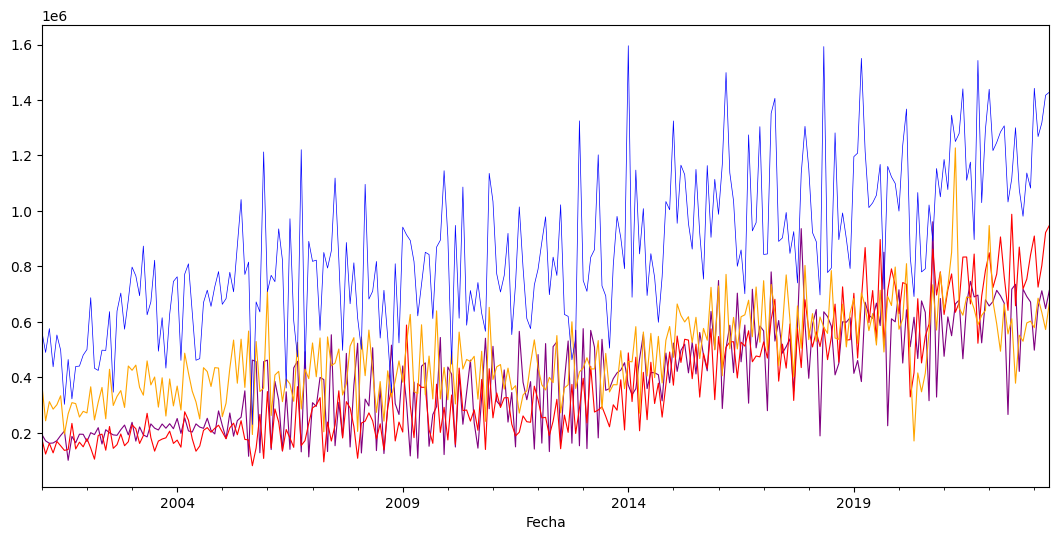

In [376]:
plt.figure(figsize=(13,6))
df_imp['Gas licuado de petróleo'].plot(color='purple', linewidth=0.8)
df_imp['Gasolina regular'].plot(color='red', linewidth=0.8)
df_imp['Gasolina superior'].plot(color='orange', linewidth=0.8)
df_imp['Diesel'].plot(color='blue', linewidth=0.5)
plt.show()

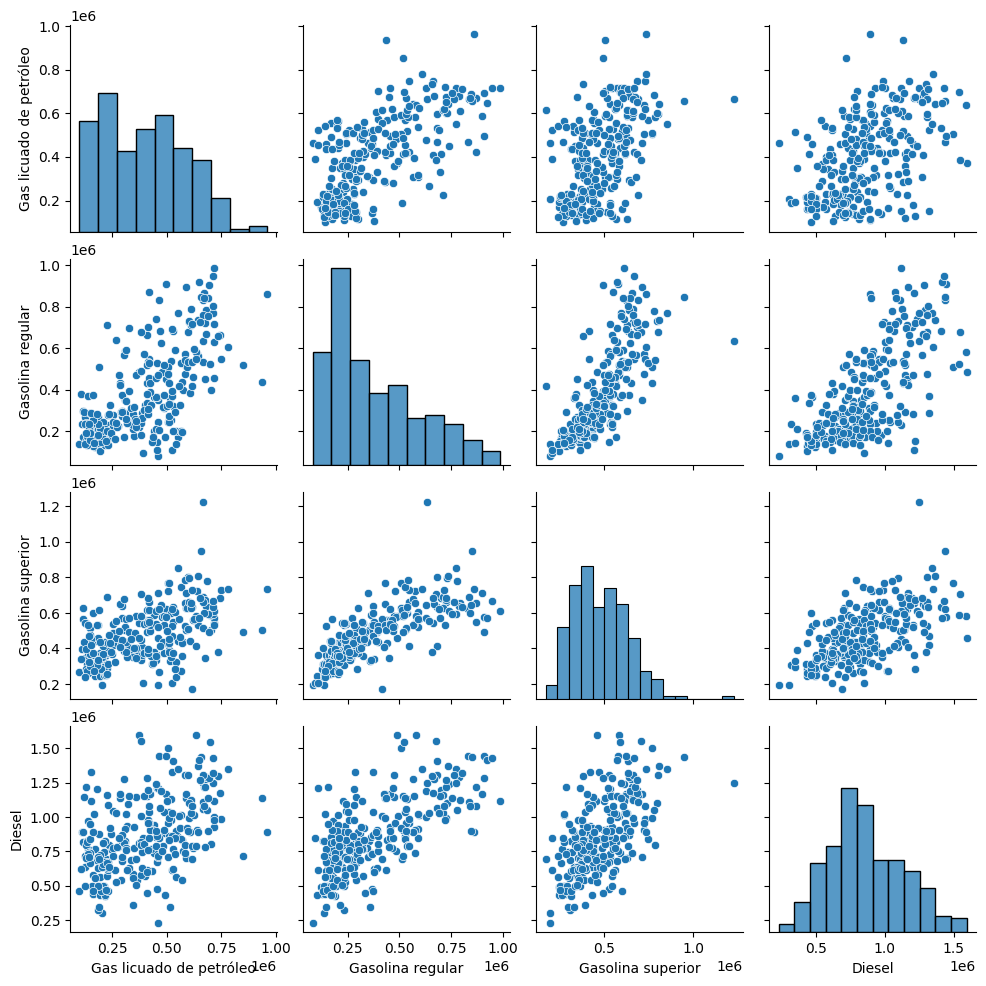

In [377]:
sns.pairplot(df_imp)
plt.show()

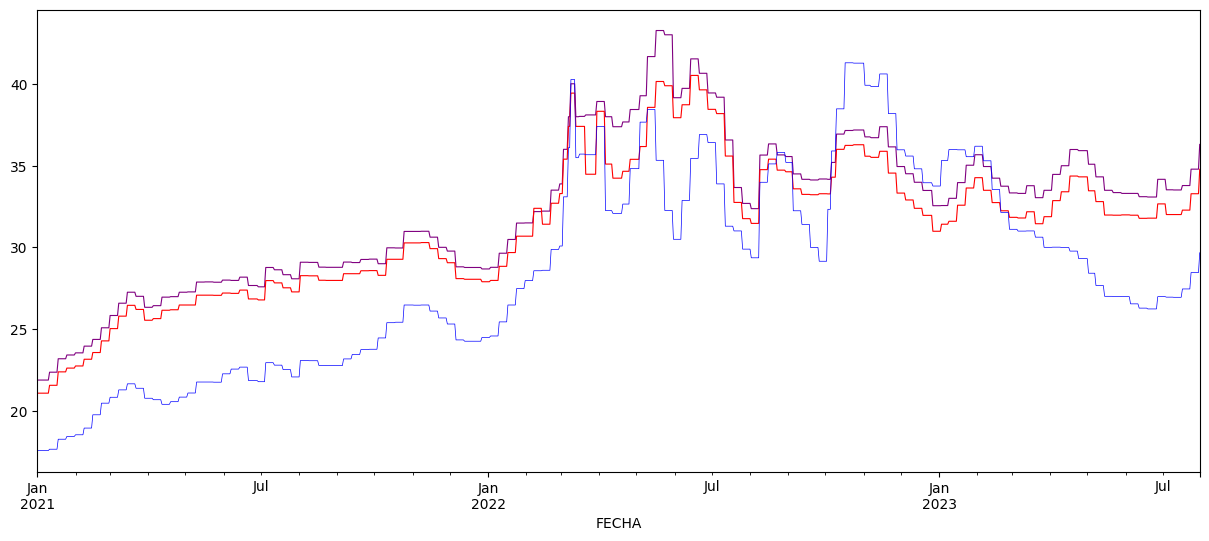

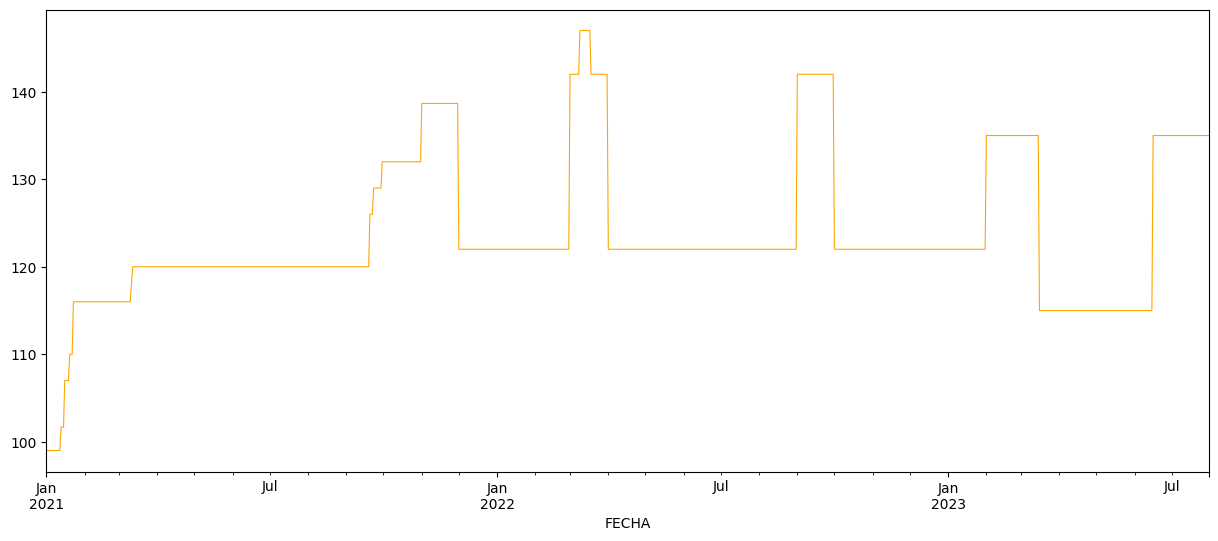

In [378]:
plt.figure(figsize=(15,6))
df_precios['Superior'].plot(color='purple', linewidth=0.8)
df_precios['Regular'].plot(color='red', linewidth=0.8)
df_precios['Diesel'].plot(color='blue', linewidth=0.5)
plt.show()

plt.figure(figsize=(15,6))
df_precios['Glp Cilindro 25Lbs.'].plot(color='orange', linewidth=0.8)
plt.show()

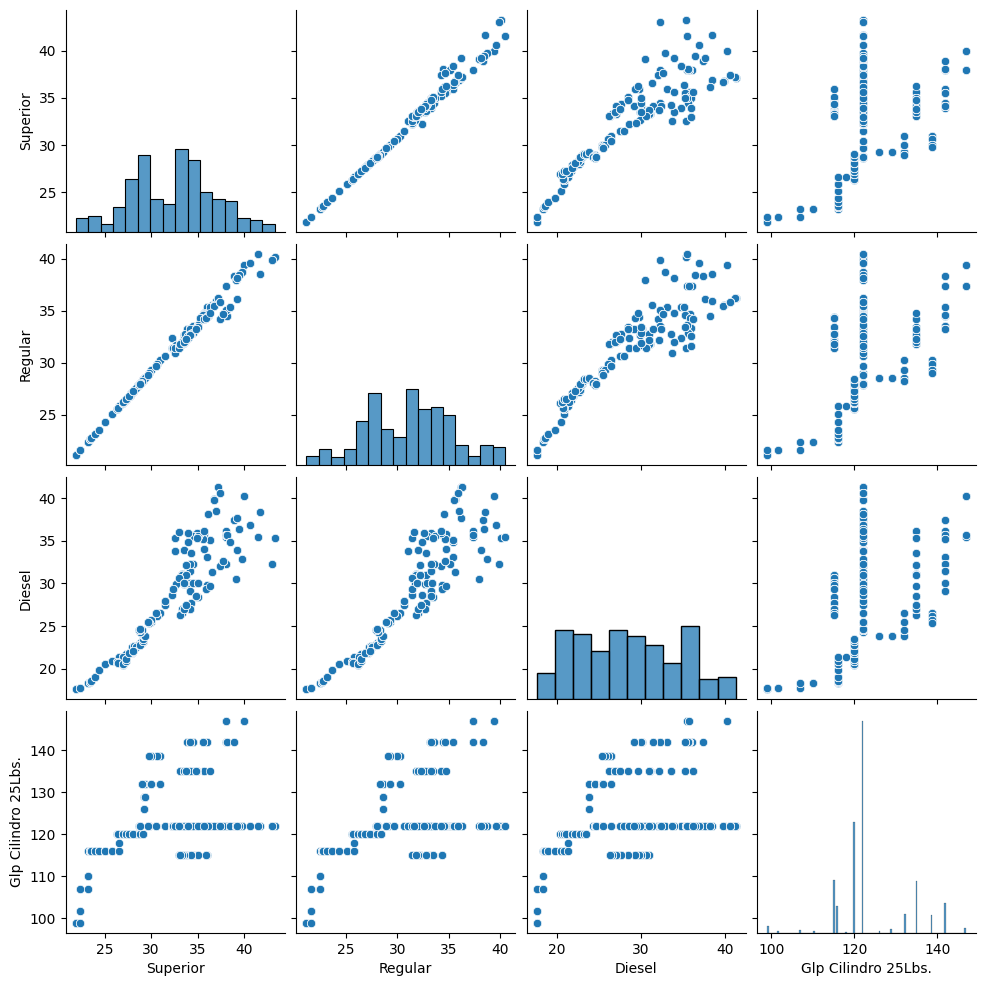

In [379]:
sns.pairplot(df_precios)
plt.show()

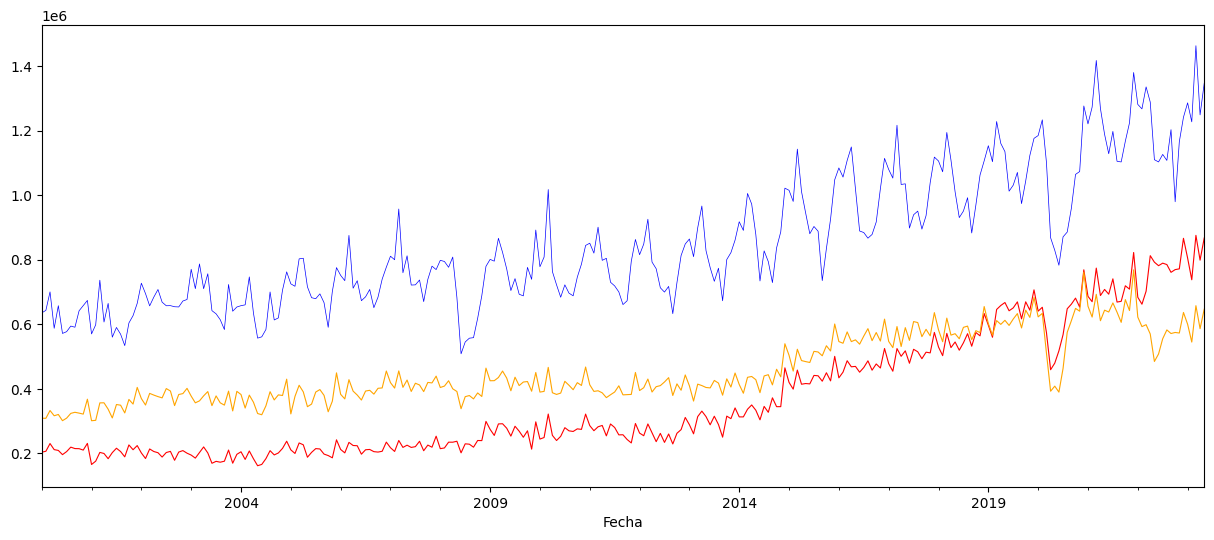

In [380]:
plt.figure(figsize=(15,6))
df_consumo['Gasolina regular'].plot(color='red', linewidth=0.8)
df_consumo['Gasolina superior'].plot(color='orange', linewidth=0.8)
df_consumo['Diesel'].plot(color='blue', linewidth=0.5)
plt.show()

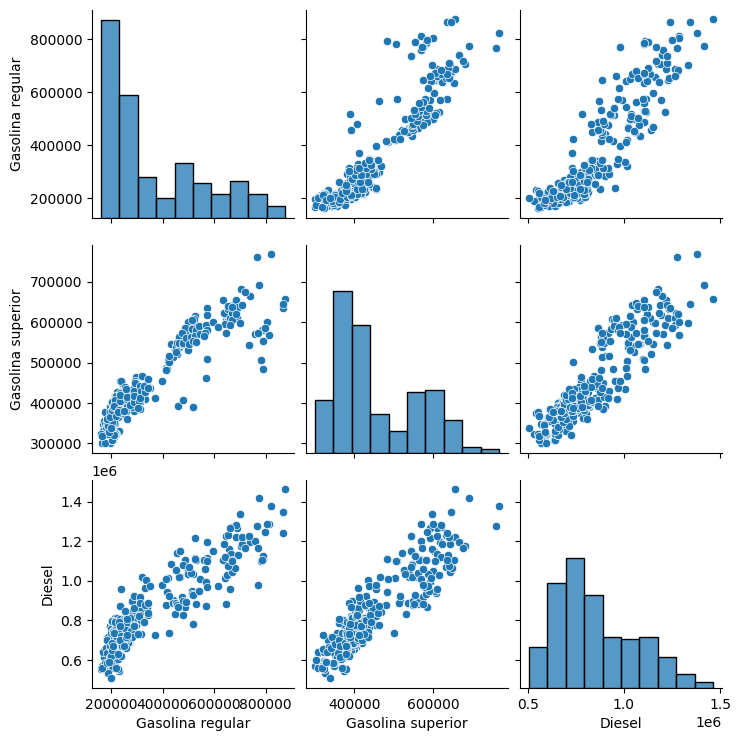

In [381]:
sns.pairplot(df_consumo)
plt.show()

# ARIMA

Hemo decidio utilizar las siguientes columnas para trabajar con arima:
- Importacion: Gas licuado de petróleo como df1
- Precios: Gasolina superior como df2
- Consumo: Diesel df3

In [382]:
df1 = df_imp[['Gasolina regular']]
df2 = df_precios['Superior']
df3 = df_consumo['Diesel']
df1.head(), df2.head(), df3.head()

(            Gasolina regular
 Fecha                       
 2001-01-01         177776.50
 2001-02-01         123115.99
 2001-03-01         161726.42
 2001-04-01         127338.74
 2001-05-01         168730.19,
 FECHA
 2021-01-01    21.91
 2021-01-02    21.91
 2021-01-03    21.91
 2021-01-04    21.91
 2021-01-05    21.91
 Name: Superior, dtype: float64,
 Fecha
 2000-01-01    634667.06
 2000-02-01    642380.66
 2000-03-01    699807.25
 2000-04-01    586803.98
 2000-05-01    656948.20
 Name: Diesel, dtype: float64)

### Importacion de Gas Licuado
#### Exploracion

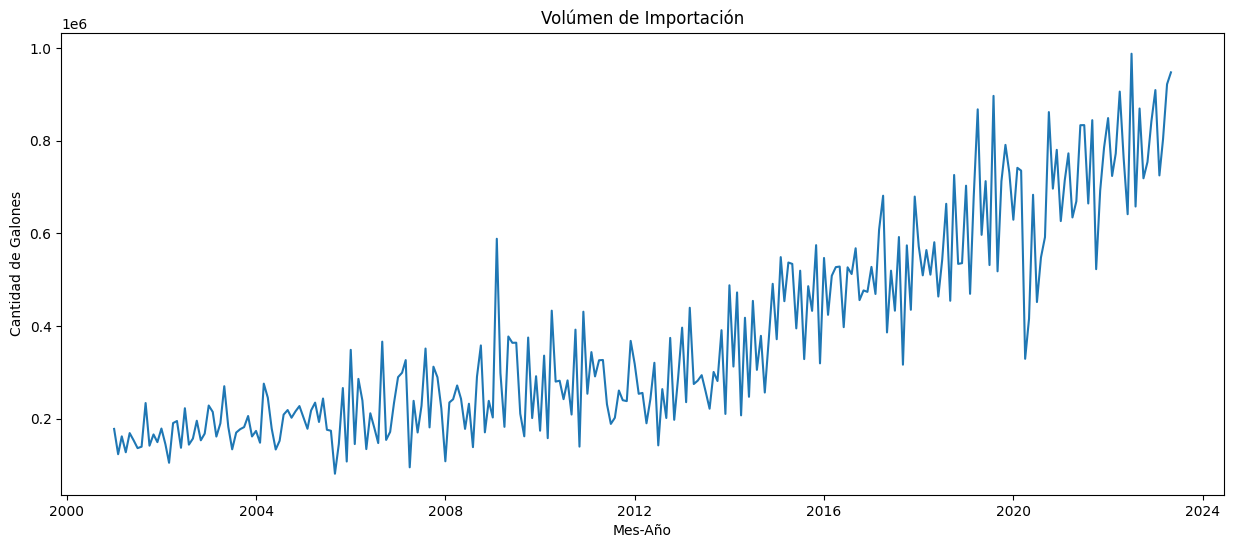

In [383]:
plt.figure(figsize=(15,6))
plt.plot(df1)
plt.gca().set(title="Volúmen de Importación", xlabel="Mes-Año", ylabel="Cantidad de Galones")
plt.show()

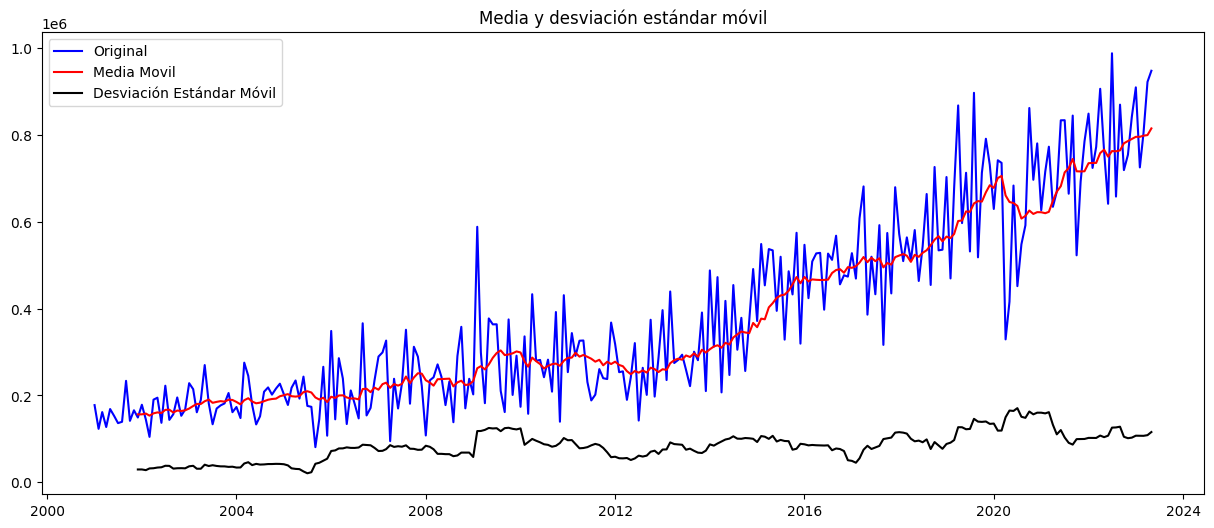

In [384]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = df1.rolling(window=12).mean()
deMovil = df1.rolling(window=12).std()
# Se grafican los resultados.
plt.figure(figsize=(15,6))
original = plt.plot(df1, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

Se observa que ni la media ni la varianza son estacionarias

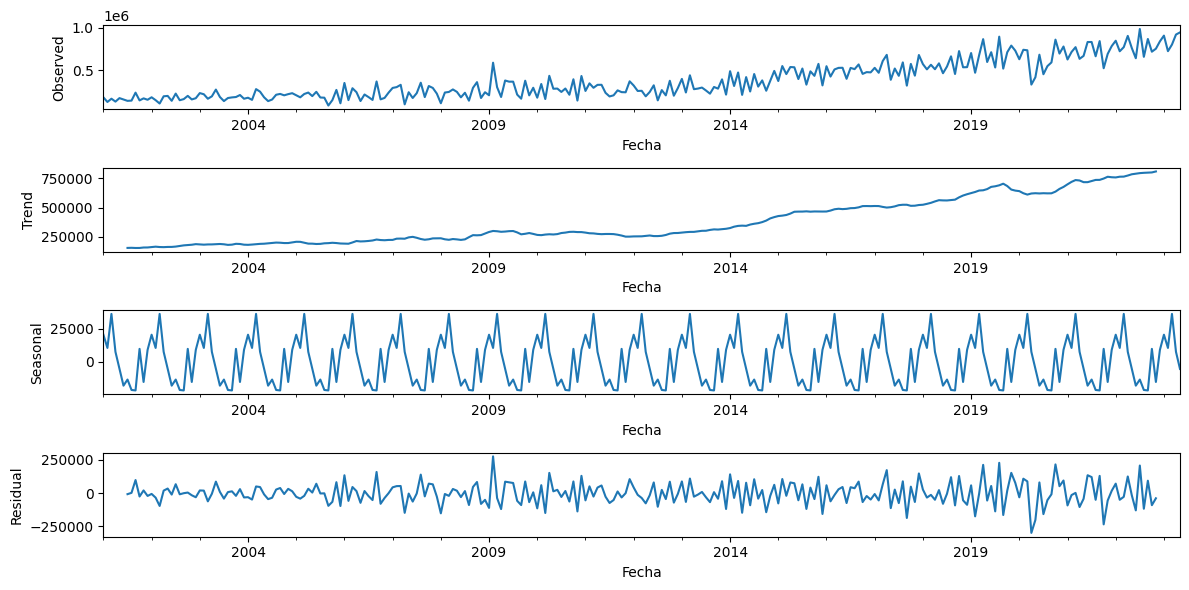

In [385]:
result = seasonal_decompose(df1)
# Create a new figure with a specific size
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 6))

# Plot the components on separate subplots
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

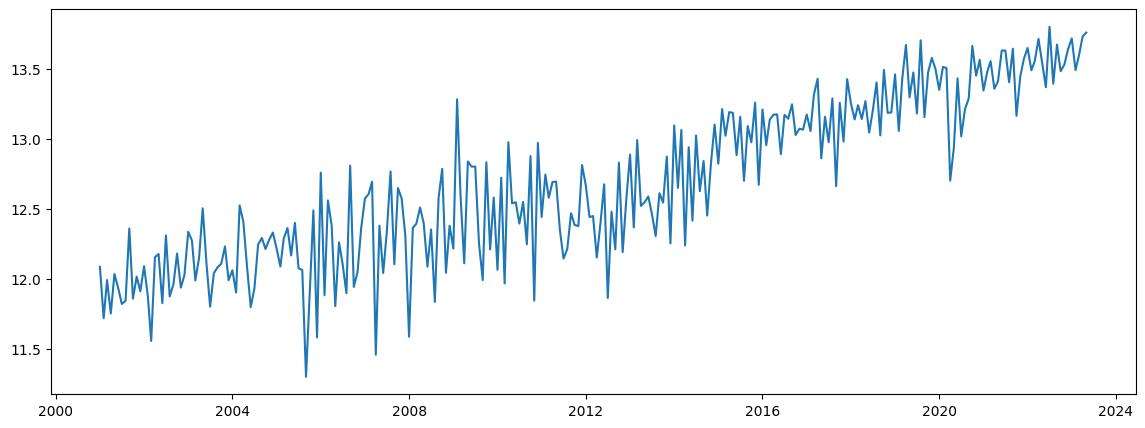

In [386]:
df1_log = np.log(df1)
plt.plot(df1_log)

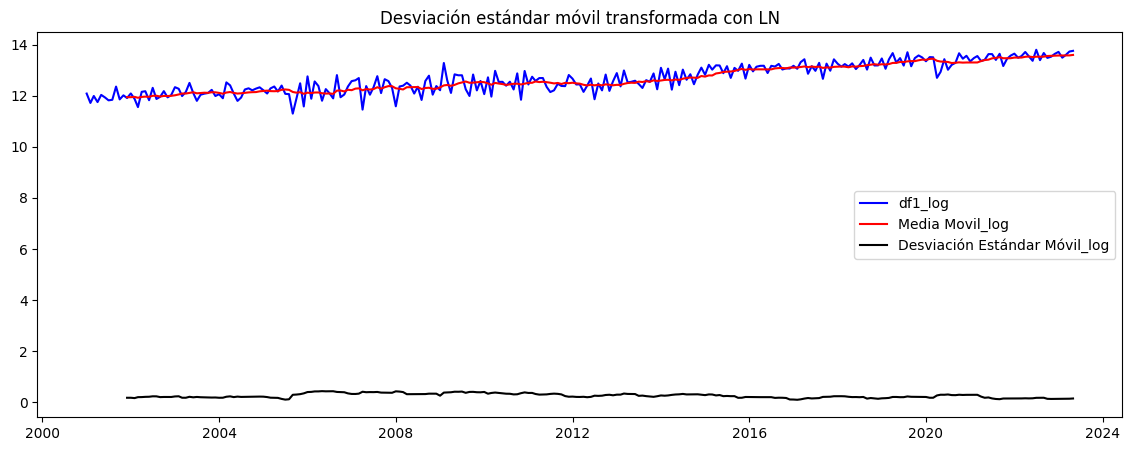

In [387]:
mediaMovil_log = df1_log.rolling(window=12).mean()
deMovil_log = df1_log.rolling(window=12).std()
#Graficando los resultados con logaritmo.
serie_df1_log = plt.plot(df1_log, color="blue", label="df1_log")
media_movil_df1_log = plt.plot(mediaMovil_log, color='red', label = 'Media Movil_log')
ds_log = plt.plot(deMovil_log,color='black', label = 'Desviación Estándar Móvil_log')
plt.legend(loc = 'best')
plt.title('Desviación estándar móvil transformada con LN')
plt.show(block=False)

La varianza parace ser mucho más estable ahora

In [388]:
print('\033[1mResultados del Test de Dickey Fuller de la serie Importación Gasolina Regular\033[0m')
df1_test = adfuller(df1, autolag='AIC')
salida_df1 = pd.Series(df1_test[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in df1_test[4].items():
        salida_df1['Critical Value (%s)'%key] = value
print(salida_df1)

Resultados del Test de Dickey Fuller de la serie Importación Gasolina Regular
Estadístico de prueba          1.090748
p-value                        0.995137
# de retardos usados           9.000000
# de observaciones usadas    259.000000
Critical Value (1%)           -3.455853
Critical Value (5%)           -2.872765
Critical Value (10%)          -2.572752
dtype: float64


El valor p e mayor a 0.05 se procede a diferenciar 1 vez

In [389]:
print('\033[1mResultados del Test de Dickey Fuller para 1 diferenciación de la serie Importación Gasolina regular\033[0m')
df1_diff = df1.diff()
df1_diff.dropna(inplace=True)
df1_test = adfuller(df1_diff)
salida_df1 = pd.Series(df1_test[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in df1_test[4].items():
        salida_df1['Critical Value (%s)'%key] = value
print(salida_df1)

Resultados del Test de Dickey Fuller para 1 diferenciación de la serie Importación Gasolina regular
Estadístico de prueba       -9.852868e+00
p-value                      4.437791e-17
# de retardos usados         8.000000e+00
# de observaciones usadas    2.590000e+02
Critical Value (1%)         -3.455853e+00
Critical Value (5%)         -2.872765e+00
Critical Value (10%)        -2.572752e+00
dtype: float64


El p-valor es menor a 0.05 se rechaza la hipótesis nula, Ha: No hay raices unitarias se acepta

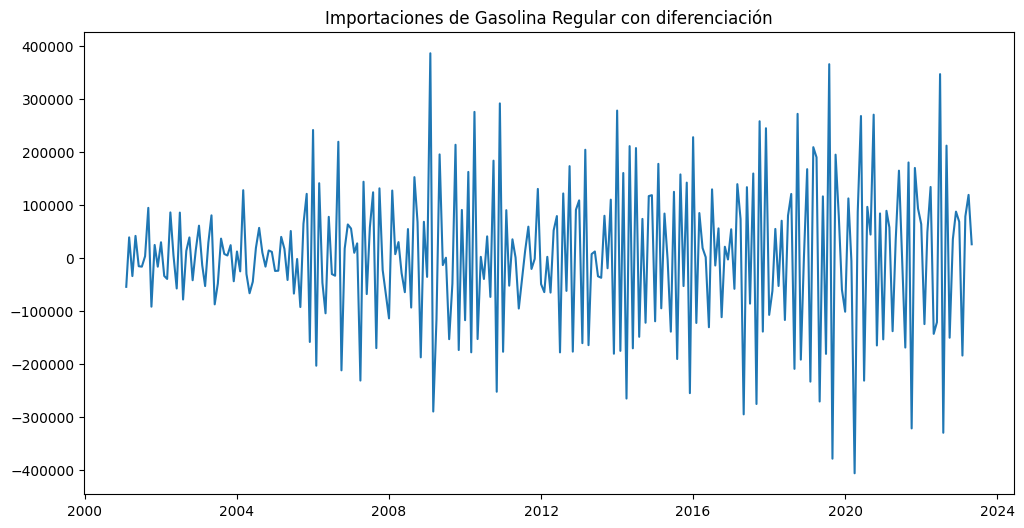

In [390]:
plt.figure(figsize=(12, 6))
plt.title('Importaciones de Gasolina Regular con diferenciación')
plt.plot(df1_diff)

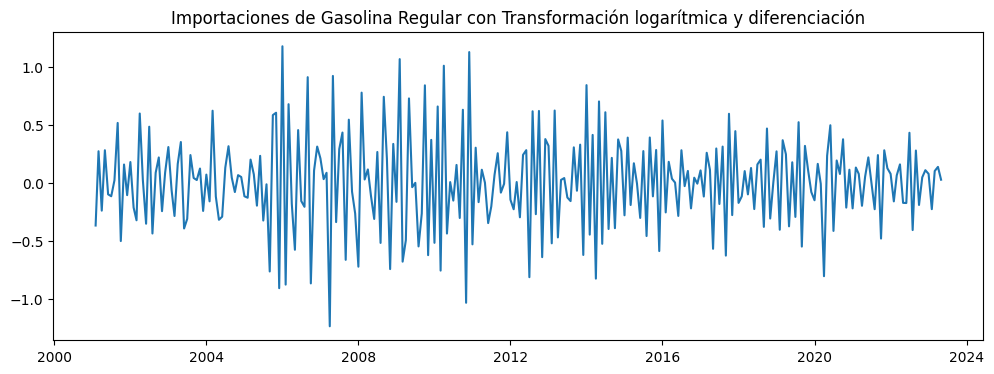

In [391]:
plt.figure(figsize=(12, 4))
df1_log_diff = df1_log.diff()
plt.title('Importaciones de Gasolina Regular con Transformación logarítmica y diferenciación')
plt.plot(df1_log_diff)

In [392]:
df1_log_diff.dropna(inplace = True)
df1_log_diff_acf = acf(df1_log_diff,nlags=5,fft=False)
df1_log_diff_pacf = pacf(df1_log_diff, nlags=36)
df1_log_diff_acf, df1_log_diff_pacf

(array([ 1.        , -0.63980275,  0.22972522, -0.1397927 ,  0.05508003,
         0.03811285]),
 array([ 1.        , -0.64219901, -0.30798694, -0.27215995, -0.25438727,
        -0.10156584, -0.04916746, -0.2515719 , -0.109741  , -0.19573169,
        -0.12725689, -0.06880904,  0.02507143, -0.17524294, -0.09741736,
        -0.05721368,  0.00913106,  0.10158407, -0.15873323, -0.15162316,
        -0.03222279, -0.0305563 ,  0.00159169, -0.04679743, -0.09825368,
        -0.12212896, -0.01962758,  0.01365864,  0.05888865, -0.03679905,
         0.09447004, -0.06584161,  0.02074825,  0.03536952, -0.24681957,
         0.1588869 ,  0.03900979]))

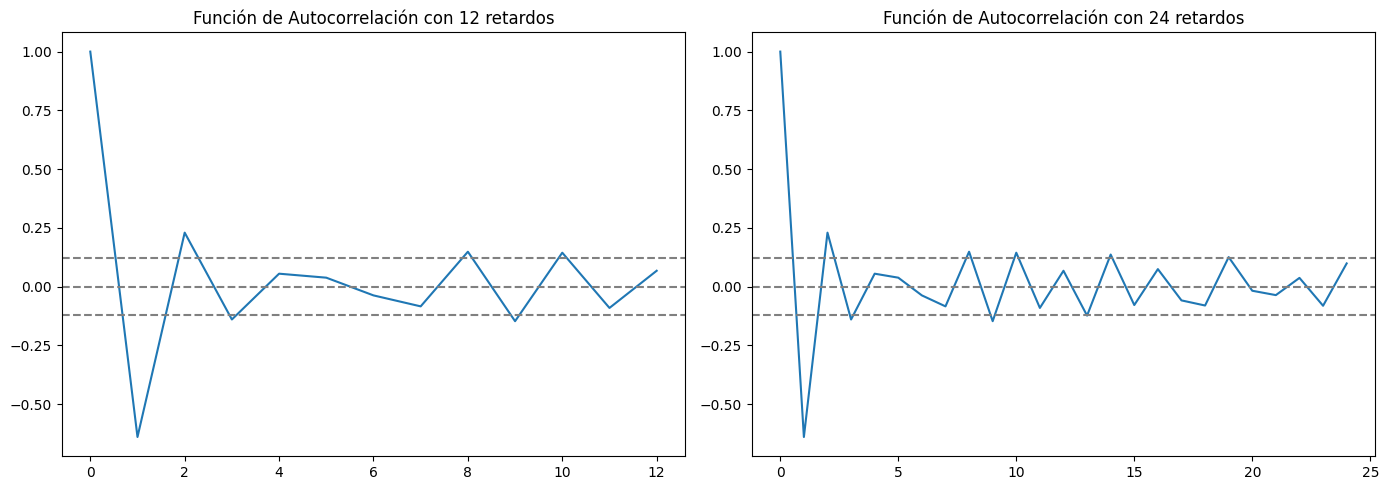

In [393]:
plt.rcParams['figure.figsize'] = [14, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(df1_log_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df1_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df1_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(df1_log_diff,nlags=24,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df1_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df1_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 24 retardos')

plt.tight_layout()

<Figure size 1000x600 with 0 Axes>

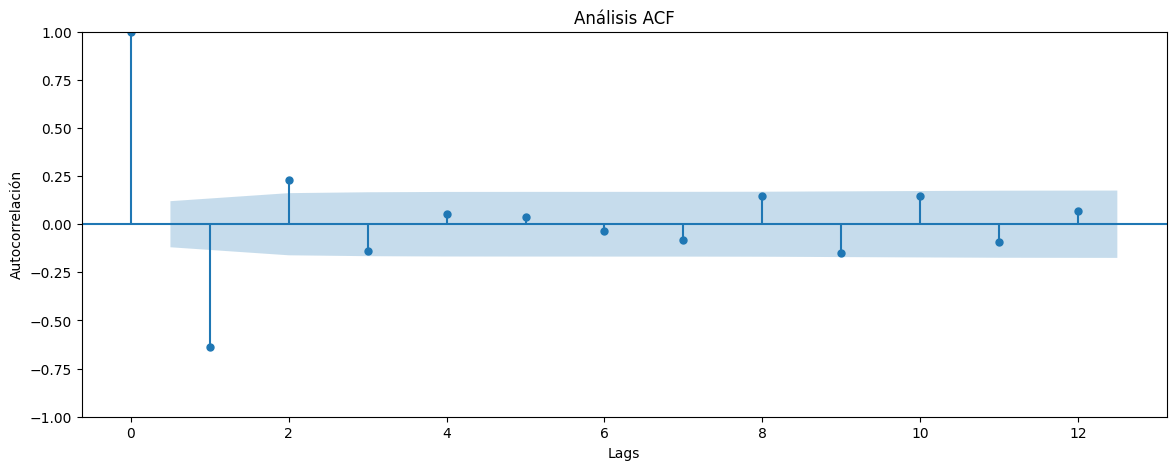

In [394]:
plt.figure(figsize=(10, 6))
plot_acf(df1_log_diff, lags=12)
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.title('Análisis ACF')
plt.show()

#### Se sugiere un valor de desde de 2 o 3 para el Q

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

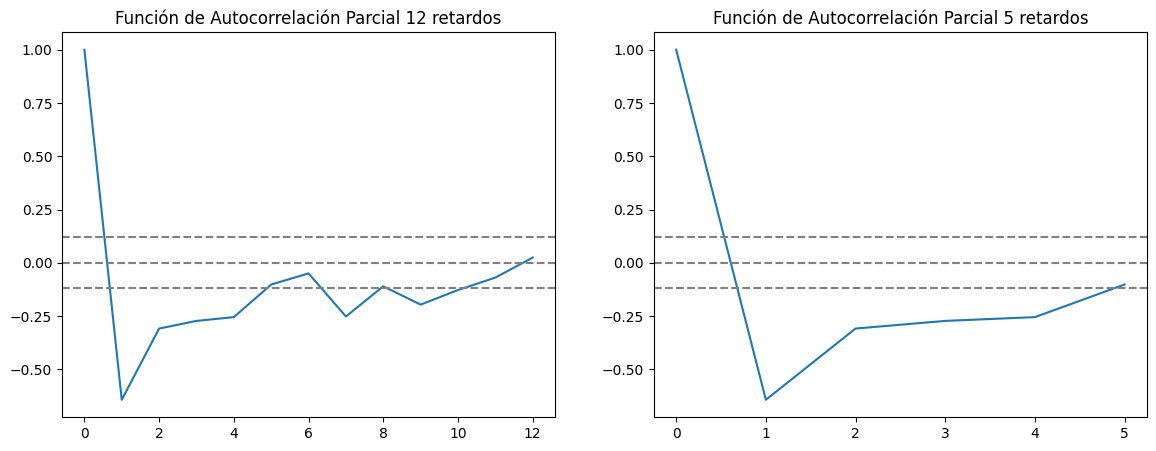

In [395]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(df1_log_diff, nlags=12))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df1_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df1_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 12 retardos')

plt.subplot(122)
plt.plot(pacf(df1_log_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df1_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df1_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

<Figure size 1000x600 with 0 Axes>

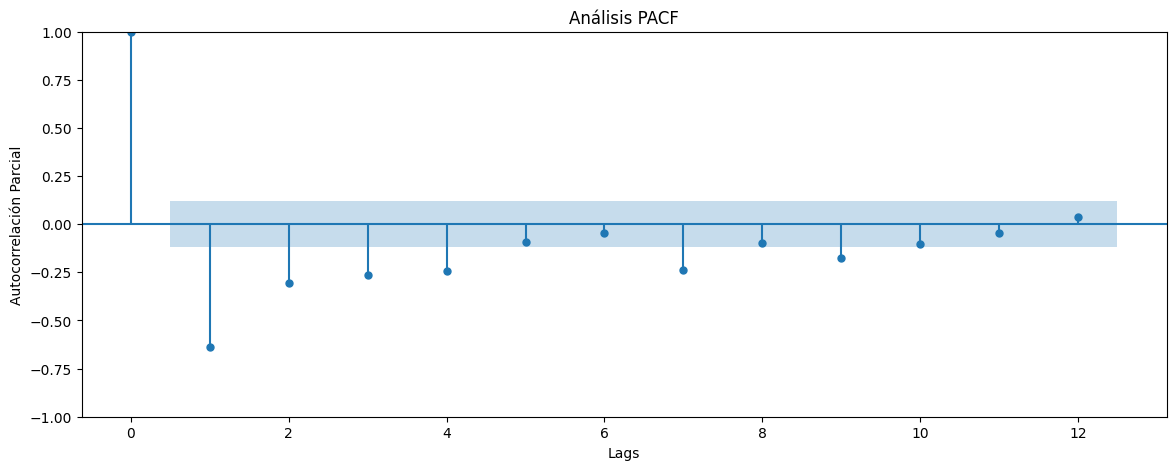

In [396]:
plt.figure(figsize=(10, 6))
plot_pacf(df1_log_diff, lags=12)
plt.xlabel('Lags')
plt.ylabel('Autocorrelación Parcial')
plt.title('Análisis PACF')
plt.show()

#### para el P podemos usar 5

No parece haber estacionalidad

In [397]:
#df1_log = df1_log.resample("M").last()
df1_modelo512 = ARIMA(df1_log, order=(5,1,2), freq ='MS')
resultado_df1_modelo512 = df1_modelo512.fit()
print(resultado_df1_modelo512.summary().tables[1])

C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4176      1.127     -0.370      0.711      -2.627       1.792
ar.L2          0.0011      0.336      0.003      0.997      -0.657       0.660
ar.L3         -0.0622      0.111     -0.562      0.574      -0.279       0.155
ar.L4         -0.0107      0.155     -0.069      0.945      -0.314       0.292
ar.L5          0.0508      0.090      0.564      0.573      -0.126       0.228
ma.L1         -0.6448      1.128     -0.572      0.568      -2.856       1.566
ma.L2         -0.1558      0.889     -0.175      0.861      -1.898       1.586
sigma2         0.0711      0.006     12.781      0.000       0.060       0.082


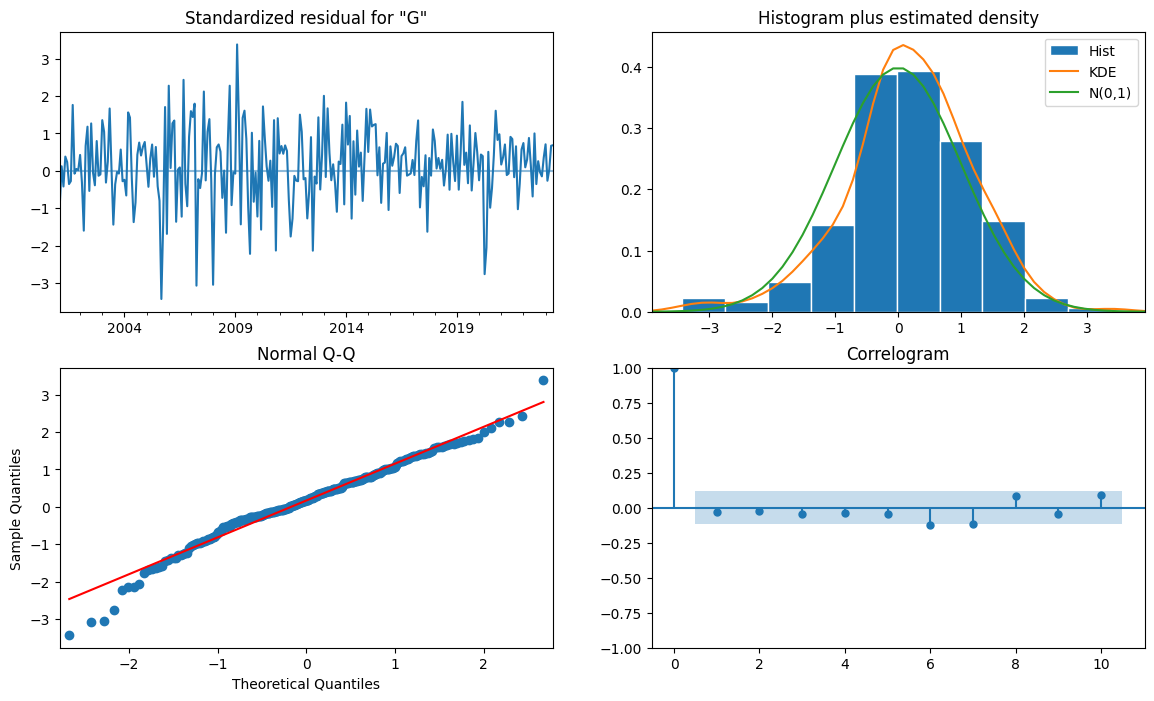

In [398]:
resultado_df1_modelo512.plot_diagnostics(figsize=(14, 8))
plt.show()

Los residuos presentan una distribución normal, y parecen comportarse como un ruido blanco dado que en el correlograma no hay autocorrelaciones significativas

In [399]:
df1_modelo513 = ARIMA(df1_log, order=(5,1,3), freq ='MS')
resultado_df1_modelo513 = df1_modelo513.fit()
print(resultado_df1_modelo513.summary().tables[1])

C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1688      0.089    -13.100      0.000      -1.344      -0.994
ar.L2         -1.0354      0.149     -6.938      0.000      -1.328      -0.743
ar.L3         -0.1934      0.176     -1.099      0.272      -0.538       0.152
ar.L4         -0.0223      0.126     -0.176      0.860      -0.270       0.225
ar.L5         -0.0084      0.073     -0.115      0.909      -0.151       0.134
ma.L1          0.1340      0.073      1.830      0.067      -0.009       0.277
ma.L2          0.1134      0.072      1.578      0.115      -0.027       0.254
ma.L3         -0.7948      0.062    -12.820      0.000      -0.916      -0.673
sigma2         0.0665      0.005     13.134      0.000       0.057       0.076


C:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


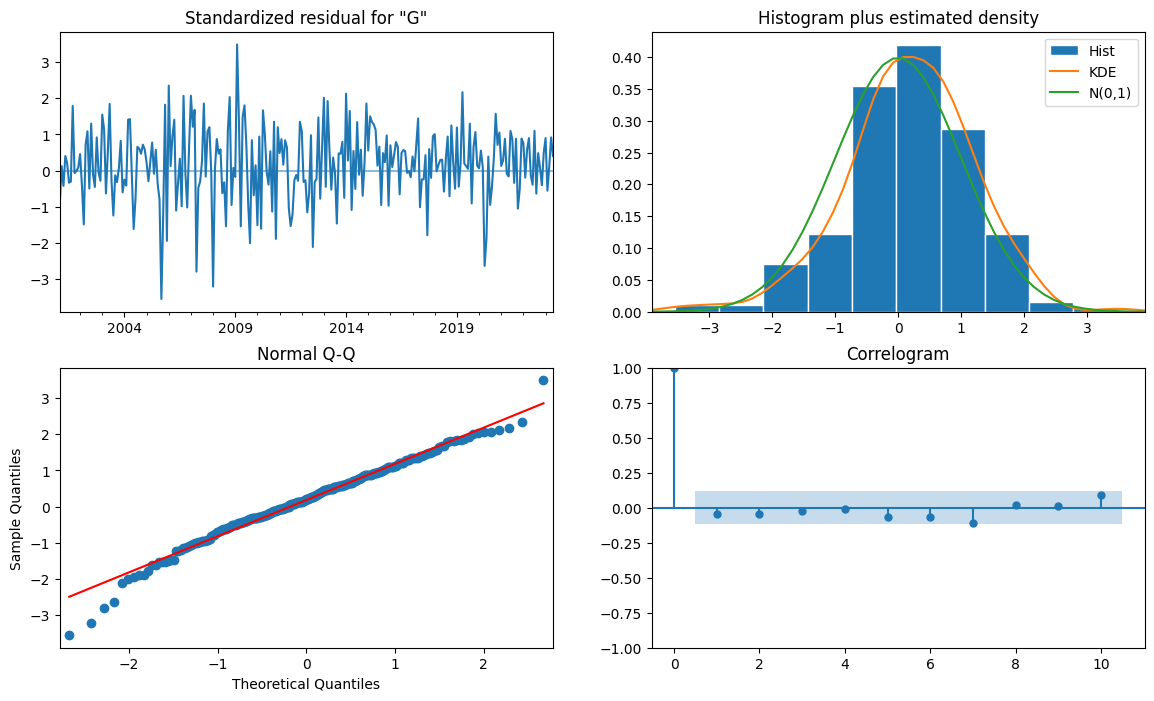

In [400]:
resultado_df1_modelo513.plot_diagnostics(figsize=(14, 8))
plt.show()

In [401]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 512=",resultado_df1_modelo512.aic)
print("Modelo 513=",resultado_df1_modelo513.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 512=",resultado_df1_modelo512.bic)
print("Modelo 513=",resultado_df1_modelo513.bic)

Resultados de AIC (Akaike information criterion)
Modelo 512= 69.58469066398085
Modelo 513= 63.1471808178021
Resultados de BIC (Bayesian information criterion)
Modelo 512= 98.31258650806771
Modelo 513= 95.4660636423998


De acuerdo a ambos indicadores es mejor el modelo p=5, d=1, q=3 por lo que este es el que será usado para predecir pues tinene un valor menor en AIC y en BIC
### Predicción Importaciones de Gasolina Regular con el mejor modelo

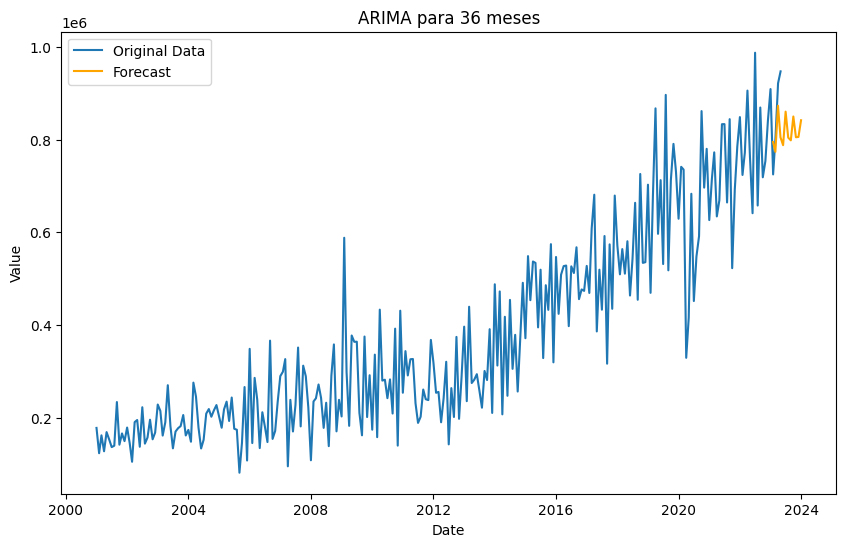

In [422]:
# Generate forecast for the next 12 months
forecast_steps = 12
forecast = resultado_df1_modelo513.forecast(steps=forecast_steps)
forecast_original_scale = np.exp(forecast)

# Create a date range for the forecasted months
last_date = df1.index[-6]  # Assuming 'df' is your original data DataFrame
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='M')[1:]

# Create a DataFrame to hold the forecasted values
forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_index)


# Plot the original data and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df1.index, df1['Gasolina regular'], label='Original Data')
plt.plot(forecast_df.index, forecast_original_scale, label='Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA para 36 meses')
plt.legend()
plt.show()